In [12]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib as mpl
import KetSugar as ks
import MaxLik as ml
import HammerProj as hp
from scipy.optimize import minimize
deg = np.pi/180

# phase dependence on header voltage
def VoltToPhase(V, alpha=0, beta=1, gamma=0):
    return alpha + beta*V + gamma*V*V

# inversion of the phase dependence
def GetV(phi, alpha=0, beta=1, gamma=0):
    sqroot = (beta*beta - 4*(alpha-phi)*gamma)**0.5
    x1 = 0.5*(-beta + sqroot)/gamma
    x2 = 0.5*(-beta - sqroot)/gamma
    return x1, x2

def DetectUnitary(voltage1, voltage2, params1, params2):
    """
    Unitary matrix of interferometer with input phase shift        
    """
    phi1 = VoltToPhase(voltage1, params1[0], params1[1], params1[2])
    phi2 = VoltToPhase(voltage2, params2[0], params2[1], params2[2])    
    t = (1 - np.exp(phi2*1j))*0.5
    r = (1 + np.exp(phi2*1j))*0.5
    exp1 = np.exp(phi1*1j)
    U = np.array([[t, r*exp1],[r,t*exp1]])
    return U

def GenerateProjectors(indices, vtable1, vtable2, params1, params2):
    """
    Transform voltages into phases and then phases into measurement operators.
    """
    projectors = []
    for i1, i2 in indices:
        U = DetectUnitary(vtable1[i1][1], vtable2[i2][1], params1, params2)
        bra = ks.dagger(ks.LO) @ U
        proj = ks.dagger(bra) @ bra
        projectors.append(proj)
    return np.array(projectors)

def hammer_map(rho):
    """
    Map largest eigenstate of the density matrix to Hammer-projected surface of the Bloch sphere.
    """
    return hp.Hammer(*hp.BlochToGeo(*hp.RhoToBloch2(rho)), wrapback=True)


In [13]:
#initially assumed parameters
alp0A = -1.75
bet0A = 0.1
gam0A = 0.05
params0A = [alp0A, bet0A, gam0A]

alp0B = -1.8
bet0B = 0.11
gam0B = 0.05
params0B = [alp0B, bet0B, gam0B]

#true parameters
alp1A = -1.887
bet1A = 0.105
gam1A = 0.05
params1A = [alp1A, bet1A, gam1A]

alp1B = -1.805
bet1B = 0.115
gam1B = 0.05
params1B = [alp1B, bet1B, gam1B]

#Voltage tables for desired values of phase shifts.
volts_table_A = [
    [0, 5],
    [np.pi/2, 7.211],
    [np.pi, 8.941],
    [3*np.pi/2, 10.412]
]
volts_table_B = [
    [0,5],
    [np.pi/2,7.184],
    [np.pi,8.902],
    [3*np.pi/2,10.366]
]
volt_indices = [
    [0,2], #H
    [0,0], #V
    [3,1], #D
    [1,1], #A
    [2,1], #R
    [0,1] #L    
]

x0 = [alp0A, bet0A, gam0A, alp0B, bet0B, gam0B]
eps=.001
x00 = [alp1A+eps, bet1A+eps, gam1A+eps, alp1B+eps, bet1B+eps, gam1B+eps]
x1 = [alp1A, bet1A, gam1A, alp1B, bet1B, gam1B]


def PurityScore(datas, params):
    """
    Get purity modulation of probe states (provided as list of tomograms) assuming phase shifter parameters and known
    voltage values.
    """
    proj = GenerateProjectors(
        volt_indices, 
        volts_table_A,
        volts_table_B,
        [params[0], params[1], params[2]],
        [params[3], params[4], params[5]]
        )
    params = [proj, 1000, 1e-10]
    kwargs = {'RhoPiVect' : True, 'Renorm' : True}
    rhos = [ml.Reconstruct(tomogram, *params, **kwargs) for tomogram in datas]    
    purs = [ks.Purity(rho).real for rho in rhos]    
    return np.ptp(purs)

def get_cost_function(datas):
    def minim(x):
        return PurityScore(datas, x)
    return minim


In [14]:
# Produce simulated tomograms of probe states

projs_true = GenerateProjectors(volt_indices, volts_table_A, volts_table_B, params1A, params1B)

points = []
datas = []
coords = np.load('probes_samplings.npz')['n26']
for theta, phi in coords:
    ket = ks.BlochKet(theta, phi)
    data = []
    for proj in projs_true:
        amp = ks.ExpectationValue(ket, proj)*1000
        data.append(amp)
    data = np.array(data)
    datas.append(data)

np.save("simulated_tomo_data_2.npy", np.array(datas))

In [15]:
# Load simulated tomograms of probe states
datas = np.load("simulated_tomo_data_2.npy")
# Get cost function for minimization - i.e. minimize purity modulation.
cost_function = get_cost_function(datas)

In [16]:
print("minimize...")
R = minimize(cost_function, x00, method='Nelder-Mead')
x2 = R['x']
print(R['x'], R['fun'], R['success'])
print(x1)
x2 = R['x']
np.save('optimfit_2.npy', x2)

minimize...
[-1.96512915  0.10868928  0.04978705 -1.80490459  0.11500947  0.04999847] 0.00044816630925326173 True
[-1.887, 0.105, 0.05, -1.805, 0.115, 0.05]


In [17]:
# Load previously saved optimization result.
x2 = np.load('optimfit_2.npy')
deviation_from_optimum = np.linspace(-0.005,0.005, 21)
partial_cost_function = lambda x: cost_function(list(x2[:-1])+[x2[-1]+x])
yvals = np.array([partial_cost_function(x) for x in deviation_from_optimum])

[-1.887  0.105  0.05  -1.805  0.115  0.05 ]
[-1.965  0.109  0.05  -1.805  0.115  0.05 ]
0.0004592200991577755 0.00044816630925326173


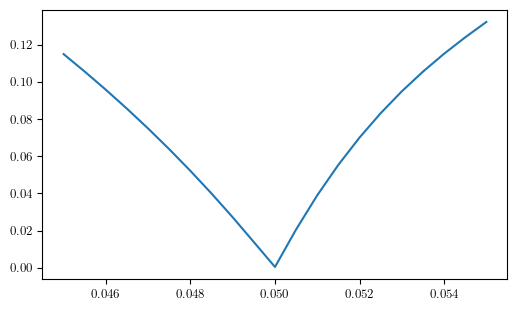

In [22]:
#Raw plot of cut-through the optimization landscape
print(np.round(x1,3))
print(np.round(x2,3))
print(cost_function(x1), cost_function(x2)) 
plt.plot(deviation_from_optimum + x2[-1], yvals)
plt.show()

In [23]:
# Target probe states
Nx = 9
Ny = 9
thetas = np.linspace(0, 180, Ny)*deg
phis = np.linspace(-180, 180, Nx)[1:]*deg
#targets = [ks.LO, ks.HI, ks.HLO, ks.HHI, ks.CLO, ks.CHI]
targets = []
for theta in thetas:
    for phi in ([0] if (theta == 0 or theta == np.pi) else phis):
        targets.append(ks.BlochKet(theta, phi))
target_rhos = [ks.ketbra(ket, ket) for ket in targets]
xys_r = np.array([hammer_map(rho) for rho in target_rhos])


proj_n = GenerateProjectors(
    volt_indices, 
    volts_table_A,
    volts_table_B,
    [x0[0], x0[1], x0[2]],
    [x0[3], x0[4], x0[5]]
    )
proj_c = GenerateProjectors(
    volt_indices, 
    volts_table_A,
    volts_table_B,
    [x2[0], x2[1], x2[2]],
    [x2[3], x2[4], x2[5]]
    )    
proj_true = GenerateProjectors(
    volt_indices, 
    volts_table_A,
    volts_table_B,
    [x1[0], x1[1], x1[2]],
    [x1[3], x1[4], x1[5]]
    )  

def generate_tomogram(ket, projs):
    return np.array([ks.ExpectationValue(ket, proj).real for proj in projs])

tomograms = [generate_tomogram(ket, proj_true) for ket in targets]
kwargs = {'RhoPiVect' : True, 'Renorm' : True}
rhos_n = [ml.Reconstruct(tomogram, proj_n, 1000, 1e-10, **kwargs) for tomogram in tomograms]
rhos_c = [ml.Reconstruct(tomogram, proj_c, 1000, 1e-10, **kwargs) for tomogram in tomograms]
purs_n = np.array([ks.Purity(rho).real for rho in rhos_n])
purs_c = np.array([ks.Purity(rho).real for rho in rhos_c])

xys_n = np.array([hammer_map(rho) for rho in rhos_n])
xys_c = np.array([hammer_map(rho) for rho in rhos_c])

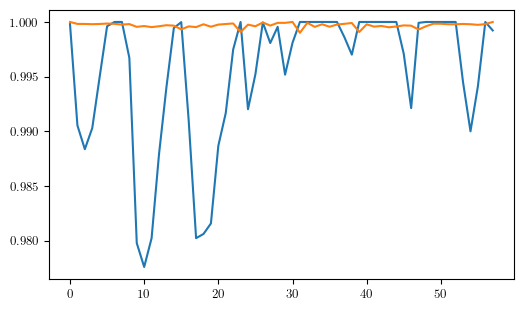

In [24]:
#Plot puritties with the assumptions of zero deviation (blue)
#and with the optimized assumptions of experimental parameter deviation
plt.plot(purs_n)
plt.plot(purs_c)
plt.show()

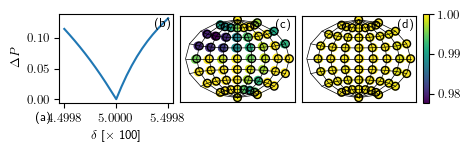

In [25]:
%matplotlib inline
# Produce plot for paper
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = 9
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['figure.figsize'] = (6, 3.5)

gridspec_kw = {'width_ratios' : [1,1,1,0.05]}
moss = """
bcdx
"""
vmin = np.min(np.concatenate([purs_n, purs_n]))
vmax = 1#np.max(np.concatenate([purs_c, purs_c]))
figsize = (7*0.7,1.5)
fig, ax = plt.subplot_mosaic(moss, gridspec_kw = gridspec_kw, figsize=figsize)
SCALE = 100
for key in 'cd':
    hp.PlotHammerGrid(ax[key], 9, 9)
    ax[key].set_aspect(1.5)
    ax[key].set_xticks([])
    ax[key].set_yticks([])    

ax['b'].plot((deviation_from_optimum + x2[-1])*SCALE, yvals)
ax['b'].set_xlabel('$\delta$ [$\\times$ 100]')
ax['b'].set_ylabel('$\Delta P$')
ticks = [
    (deviation_from_optimum[0] + x2[-1])*SCALE,
    x1[-1]*SCALE,
    (deviation_from_optimum[-1] + x2[-1])*SCALE,
]
ax['b'].set_xticks(ticks)

im0 = ax['c'].scatter(xys_n[:,0], xys_n[:,1], s = 30, c = purs_n, vmin = vmin, vmax = vmax)
ax['c'].scatter(xys_r[:,0], xys_r[:,1], s = 30, marker = 'o', edgecolors='black', facecolors='none')

im1 = ax['d'].scatter(xys_c[:,0], xys_c[:,1], s = 30, c = purs_c, vmin = vmin, vmax = vmax)
ax['d'].scatter(xys_r[:,0], xys_r[:,1], s = 30, marker = 'o', edgecolors='black', facecolors='none')
fig.colorbar(im0, cax=ax['x'])
for key in ax:
    if key != 'x':
        ax[key].text(0.84, 0.86, f'({key})', transform = ax[key].transAxes)
ax['b'].text(-0.2, -0.2, '(a)', transform = ax['b'].transAxes)

plt.subplots_adjust(top=0.975,
bottom=0.382,
left=0.142,
right=0.896,
hspace=0.0,
wspace=0.08)
plt.show()